In [1]:
import os
import sys
from dotenv import load_dotenv, find_dotenv
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import DrDataLoader
import mlflow
import mlflow.tensorflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.tensorflow.autolog()
load_dotenv(find_dotenv())

2022-11-29 22:02:56.659065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022/11/29 22:03:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


True

In [2]:
experiment_id = mlflow.create_experiment(
    os.getenv('EXPERIMENT_NAME'), #type: ignore
    artifact_location=Path.cwd().joinpath("../artifacts").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: pipeline
Experiment_id: 1
Artifact Location: file:///Users/b7064522/Documents/DataScience/kaggle-digit-recognizer/notebooks/../artifacts
Tags: {'version': 'v1', 'priority': 'P1'}
Lifecycle_stage: active
Creation timestamp: 1669759386591


In [3]:
with mlflow.start_run(experiment_id=experiment_id):
    data_loader = DrDataLoader(Path('../') / Path(os.getenv('RAW_FP'))) #type: ignore
    train_ds, val_ds = tf.keras.utils.split_dataset(
        data_loader.load_training_data(),
        left_size = 0.8,
        shuffle=True
    )
    BATCH_SIZE = 128
    mlflow.log_param("BATCH_SIZE", BATCH_SIZE)
    train_ds = train_ds.batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)
    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])
    print(model.summary())
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)

2022-11-29 22:03:17.079900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
263/263 [==============================] - 3s 6ms/step - loss: 7.0758 - sparse_categorical_accuracy: 0.8413 - val_loss: 2.1268 - val_sparse_categorical_accuracy: 0.9046
Epoch 2/10
263/263 [==============================] - 1s 6ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.9188 - val_loss

2022/11/29 22:03:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/b7064522/opt/miniconda3/envs/kdrenv/lib/python3.10/site-packages/mlflow/tensorflow/__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: /var/folders/4g/6c1htv314w9dcb25vhpxqfscjwsh63/T/tmpyyimp3aa/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/4g/6c1htv314w9dcb25vhpxqfscjwsh63/T/tmpyyimp3aa/model/data/model/assets
2022/11/29 22:03:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/b7064522/opt/miniconda3/envs/kdrenv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


4/4 [==============================] - 0s 5ms/step
2


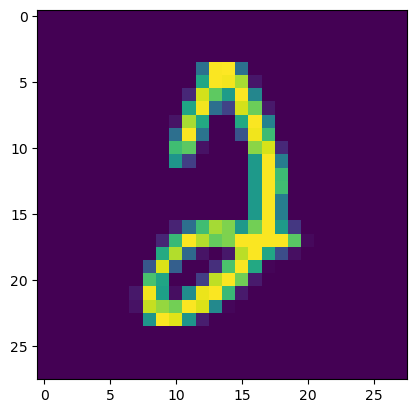

In [4]:
test_labels = model.predict(val_ds)
for batch, lab in val_ds.take(1):
    pred = model.predict(batch)
    plt.imshow(batch[127])
    print(pred[127].argmax())